In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp drive/MyDrive/Данные\ ИИ\ для\ лазерной\ обработки/Данные.zip .

In [ ]:
!unzip Данные.zip

Archive:  Данные.zip
   creating: Данные/
   creating: Данные/Annotations/
   creating: Данные/Annotations/Положение 0/
  inflating: Данные/Annotations/Положение 0/01.txt  
  inflating: Данные/Annotations/Положение 0/1.txt  
  inflating: Данные/Annotations/Положение 0/20.txt  
  inflating: Данные/Annotations/Положение 0/3.txt  
  inflating: Данные/Annotations/Положение 0/30.txt  
  inflating: Данные/Annotations/Положение 0/4.txt  
  inflating: Данные/Annotations/Положение 0/40.txt  
  inflating: Данные/Annotations/Положение 0/5.txt  
  inflating: Данные/Annotations/Положение 0/50.txt  
  inflating: Данные/Annotations/Положение 0/6.txt  
  inflating: Данные/Annotations/Положение 0/60.txt  
  inflating: Данные/Annotations/Положение 0/7.txt  
  inflating: Данные/Annotations/Положение 0/70.txt  
  inflating: Данные/Annotations/Положение 0/8.txt  
  inflating: Данные/Annotations/Положение 0/80.txt  
  inflating: Данные/Annotations/Положение 0/85.txt  
  inflating: Данные/Annotations/Положен

1 - Преобразование данных в нормальный вид

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# ==== ПУТИ ====
ROOT_DIR = "Данные"
XLSX_PATH = os.path.join(ROOT_DIR, "Координаты.xlsx")
OUTPUT_DIR = "dataset"

IMG_SIZE = (512, 256)  # (W, H)
ORIG_WIDTH, ORIG_HEIGHT = 2048, 1088
NUM_CLASSES = 3

# ==== ВЫХОДНЫЕ ПАПКИ ====
for subset in ["train", "val"]:
    os.makedirs(f"{OUTPUT_DIR}/images/{subset}", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/masks/{subset}", exist_ok=True)

# ==== ЗАГРУЗКА XLSX ====
df = pd.read_excel(XLSX_PATH)
df["folder"] = df["Положение "].str.strip()
df = df.set_index("folder")

# ==== ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЙ ====
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Ошибка чтения изображения: {image_path}")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    normalized = clahe.apply(image)
    blurred = cv2.GaussianBlur(normalized, (5, 5), 0)
    return cv2.resize(blurred, IMG_SIZE)  # uint8, (H, W)

# ==== КОНВЕРТАЦИЯ YOLO В БИНАРНЫЕ МАСКИ ====
def denormalize_coords(coords, width, height):
    coords = np.array(coords).reshape(-1, 2)
    coords[:, 0] *= width
    coords[:, 1] *= height
    return coords.astype(np.int32)

def generate_binary_mask(txt_path, height=ORIG_HEIGHT, width=ORIG_WIDTH, out_size=IMG_SIZE, num_classes=NUM_CLASSES):
    masks = np.zeros((num_classes, height, width), dtype=np.uint8)
    if not os.path.exists(txt_path):
        return np.zeros((out_size[1], out_size[0], num_classes), dtype=np.uint8)

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            class_id = int(parts[0])
            coords = list(map(float, parts[1:]))
            polygon = denormalize_coords(coords, width, height)
            cv2.fillPoly(masks[class_id], [polygon], 255)

    # Resize каждый канал
    resized_masks = [cv2.resize(m, out_size, interpolation=cv2.INTER_NEAREST) for m in masks]
    return np.stack(resized_masks, axis=-1)  # (H, W, 3)

# ==== СБОР ВСЕХ ПУТЕЙ ====
items = []  # (img_path, txt_path, folder_name, file_key)

for folder_path in sorted(glob(os.path.join(ROOT_DIR, "Положение *"))):
    folder_name = os.path.basename(folder_path)
    image_paths = sorted(glob(os.path.join(folder_path, "*.bmp")))
    for img_path in image_paths:
        fname = os.path.splitext(os.path.basename(img_path))[0]
        txt_path = os.path.join(ROOT_DIR, "Annotations", folder_name, f"{fname}.txt")
        if os.path.exists(txt_path):
            items.append((img_path, txt_path, folder_name, fname))

# ==== SPLIT ====
train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)

# ==== СОХРАНЕНИЕ ====
regression_rows = []

def process(items, split):
    for img_path, txt_path, folder_name, fname in tqdm(items, desc=f"Processing {split}"):
        try:
            img_out = preprocess_image(img_path)       # (H, W)
            mask_out = generate_binary_mask(txt_path)  # (H, W, 3)

            # Пути вывода
            img_name = f"{folder_name}_{fname}.npy"
            img_out_path = os.path.join(OUTPUT_DIR, f"images/{split}/{img_name}")
            mask_out_path = os.path.join(OUTPUT_DIR, f"masks/{split}/{img_name}")

            # Сохранение в .npy
            np.save(img_out_path, img_out.astype(np.uint8))
            np.save(mask_out_path, mask_out.astype(np.uint8))

            # Регрессионные метки
            if folder_name in df.index:
                coord_raw = df.loc[folder_name]["Координаты центра X, Y"]
                angle = df.loc[folder_name]["Угол поворота в градусах (Относительно центра образца)"]
                if isinstance(coord_raw, str) and "(" in coord_raw:
                    x, y = ast.literal_eval(coord_raw)
                    regression_rows.append({
                        "filename": f"{split}/{img_name}",
                        "x_mm": x,
                        "y_mm": y,
                        "angle_deg": angle
                    })

        except Exception as e:
            print(f"❌ Ошибка при обработке {img_path}: {e}")

# ==== ЗАПУСК ====
process(train_items, "train")
process(val_items, "val")

# ==== CSV ====
df_out = pd.DataFrame(regression_rows)
df_out.to_csv(os.path.join(OUTPUT_DIR, "labels.csv"), index=False)
print("✅ Датасет подготовлен и сохранён в", OUTPUT_DIR)

Processing val: 100%|██████████| 55/55 [00:01<00:00, 45.98it/s]

✅ Датасет подготовлен и сохранён в dataset


In [ ]:
df = pd.read_csv('dataset/labels.csv')
df

,filename,x_mm,y_mm,angle_deg
0,train/Положение 9_Image__2025-07-15__16-29-56.npy,4,18,0
1,train/Положение 9_Image__2025-07-15__16-31-08.npy,4,18,0
2,train/Положение 1_Image__2025-07-15__15-30-32.npy,4,6,37
3,train/Положение 7_Image__2025-07-15__16-10-49.npy,8,0,0
4,train/Положение 3_Image__2025-07-15__15-47-29.npy,30,-2,0
...,...,...,...,...
251,val/Положение 2_Image__2025-07-15__15-36-39.npy,0,0,0
252,val/Положение 13_Image__2025-07-15__16-52-35.npy,10,-4,42
253,val/Положение 5_Image__2025-07-15__15-56-32.npy,-5,-1,75
254,val/Положение 4_Image__2025-07-15__15-50-15.npy,7,-26,15


In [ ]:
# Очистка данных от несуществующих картинок
import cv2

df = pd.read_csv("dataset/labels.csv")
good_rows = []

for row in df.itertuples():
    img_path = os.path.join("dataset/images", row.filename)
    mask_path = os.path.join("dataset/masks", row.filename)

    print(img_path)
    img_ok = os.path.exists(img_path) and isinstance(np.load(img_path), np.ndarray)
    mask_ok = os.path.exists(mask_path) and isinstance(np.load(mask_path), np.ndarray)

    if img_ok and mask_ok:
        good_rows.append(row)

print(pd.DataFrame(good_rows))
clean_df = pd.DataFrame(good_rows)[['filename', 'x_mm', 'y_mm', 'angle_deg']]
clean_df.to_csv("dataset/labels.csv", index=False)

print(f"✔️ Очищено: {len(df)} → {len(clean_df)} строк сохранено в labels.csv")

In [ ]:
!zip -r dataset.zip dataset  # Бэкап)

  adding: dataset/ (stored 0%)
  adding: dataset/masks/ (stored 0%)
  adding: dataset/masks/val/ (stored 0%)
  adding: dataset/masks/val/Положение 4_Image__2025-07-15__15-52-04.npy (deflated 100%)
  adding: dataset/masks/val/Положение 12_Image__2025-07-15__16-47-21.npy (deflated 100%)
  adding: dataset/masks/val/Положение 2_Image__2025-07-15__15-36-39.npy (deflated 100%)
  adding: dataset/masks/val/Положение 6_Image__2025-07-15__16-00-40.npy (deflated 100%)
  adding: dataset/masks/val/Положение 2_Image__2025-07-15__15-42-03.npy (deflated 100%)
  adding: dataset/masks/val/Положение 5_Image__2025-07-15__15-55-51.npy (deflated 100%)
  adding: dataset/masks/val/Положение 12_Image__2025-07-15__16-48-13.npy (deflated 100%)
  adding: dataset/masks/val/Положение 8_Image__2025-07-15__16-21-04.npy (deflated 100%)
  adding: dataset/masks/val/Положение 3_Image__2025-07-15__15-43-11.npy (deflated 100%)
  adding: dataset/masks/val/Положение 3_Image__2025-07-15__15-46-57.npy (deflated 100%)
  adding:

In [ ]:
!apt-get install tree
!tree dataset > tree.txt

2 - Датасет

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class LaserVisionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, split="train", transform=None):
        self.image_dir = os.path.join(image_dir, split)
        self.mask_dir = os.path.join(mask_dir, split)
        self.df = pd.read_csv(csv_path)
        self.split = split
        self.transform = transform

        self.df = self.df[self.df["filename"].str.startswith(split + "/")].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]
        x, y, angle = row["x_mm"], row["y_mm"], row["angle_deg"]

        # === Загрузка изображений и масок ===
        img_path = os.path.join(self.image_dir, os.path.basename(filename))
        mask_path = os.path.join(self.mask_dir, os.path.basename(filename))

        # .npy → np.array
        image = np.load(img_path).astype(np.float32)  # [H, W]
        mask = np.load(mask_path).astype(np.float32)  # [H, W, 3]

        # === Нормализация ===
        image /= 255.0
        mask /= 255.0

        # === grayscale → RGB (3 канала) ===
        image = np.repeat(image[np.newaxis, :, :], 3, axis=0)  # [3, H, W]

        # === Преобразование в тензоры ===
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask).permute(2, 0, 1)  # [3, H, W]
        label = torch.tensor([x, y, angle], dtype=torch.float32)

        # === Аугментации (если нужны) ===
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask, label

3 - Модель

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class LaserVisionNet(nn.Module):
    def __init__(self, backbone='resnet34', num_classes=3):
        super().__init__()

        # === ЭНКОДЕР ===
        resnet = models.resnet34(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # [B, 512, H/32, W/32]

        # === DECODER для сегментации ===
        self.seg_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)
        )

        # === РЕГРЕССОР ===
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)  # x, y, theta
        )

    def forward(self, x):
        feats = self.encoder(x)             # [B, 512, H/32, W/32]
        seg_out = self.seg_decoder(feats)   # [B, 3, H, W]
        reg_out = self.regressor(feats)     # [B, 3]
        return seg_out, reg_out

In [ ]:
# Кастомный loss
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_loss = nn.BCEWithLogitsLoss()
        self.reg_loss = nn.MSELoss()

    def forward(self, seg_pred, reg_pred, seg_true, reg_true):
        loss_seg = self.seg_loss(seg_pred, seg_true)
        loss_reg = self.reg_loss(reg_pred, reg_true)
        total = loss_seg + loss_reg
        return total, loss_seg, loss_reg

4 - Обучение

In [75]:
def train_with_logging(model, train_loader, val_loader, loss_fn, optimizer, device,
                       epochs=10, scheduler=None, save_path="laser_model.pth", checkpoint_dir=None):
    model.to(device)
    history = []
    best_val_loss = float('inf')
    best_mean_rmse = float('inf')

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, val_loss = 0.0, 0.0

        for imgs, masks, labels in tqdm(train_loader, desc=f"[Epoch {epoch}] Training"):
            imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            seg_out, reg_out = model(imgs)
            loss, _, _ = loss_fn(seg_out, reg_out, masks, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if scheduler is not None:
          scheduler.step()

        # === Валидация ===
        model.eval()
        with torch.no_grad():
            for imgs, masks, labels in tqdm(val_loader, desc=f"[Epoch {epoch}] Validation"):
                imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
                seg_out, reg_out = model(imgs)
                loss, _, _ = loss_fn(seg_out, reg_out, masks, labels)
                val_loss += loss.item()

        # === Метрики ===
        def compute_iou(pred_mask, true_mask):
            pred_mask = torch.sigmoid(pred_mask) > 0.5  # [B, 3, H, W]
            true_mask = true_mask > 0.5
            ious = []

            for c in range(3):
                intersection = ((pred_mask[:, c] & true_mask[:, c])).float().sum(dim=(1, 2))
                union = ((pred_mask[:, c] | true_mask[:, c])).float().sum(dim=(1, 2))
                iou = (intersection / (union + 1e-6)).mean()
                ious.append(iou.item())

            return sum(ious) / len(ious)

        def compute_rmse(pred, true):
            return torch.sqrt(F.mse_loss(pred, true)).item()

        model.eval()
        ious, rmses = [], []

        with torch.no_grad():
            for imgs, masks, labels in tqdm(val_loader, desc=f"[Epoch {epoch}] Validation"):
                imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
                seg_out, reg_out = model(imgs)
                loss, _, _ = loss_fn(seg_out, reg_out, masks, labels)
                val_loss += loss.item()

                ious.append(compute_iou(seg_out.cpu(), masks.cpu()))
                rmses.append(compute_rmse(reg_out.cpu(), labels.cpu()))

        mean_iou = sum(ious) / len(ious)
        mean_rmse = sum(rmses) / len(rmses)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f} | IoU = {mean_iou:.3f}, RMSE = {mean_rmse:.2f}")
        history.append((epoch, train_loss, val_loss))

        # Порог допустимого ухудшения IoU или RMSE
        rmse_delta = 0.33

        # Условие: модель сохраняется, если val_loss улучшилась, и другие метрики не ухудшились значительно
        if val_loss < best_val_loss and (mean_rmse <= best_mean_rmse + rmse_delta):
            best_val_loss = val_loss
            best_mean_rmse = mean_rmse
            torch.save(model.state_dict(), save_path)
            print(f"📌 New best model saved (val loss = {best_val_loss:.4f}, IoU = {mean_iou:.3f}, RMSE = {best_mean_rmse:.2f}) → {save_path}")

        # === Сохраняем чекпоинт каждой эпохи ===
        if checkpoint_dir:
            ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}.pth")
            torch.save(model.state_dict(), ckpt_path)

    print(f"✅ Обучение завершено. Лучшая вал. потеря: {best_val_loss:.4f}")

In [7]:
train_dataset = LaserVisionDataset(
    'dataset/images',
    'dataset/masks',
    'dataset/labels.csv',
    split="train",
    transform=None
)

val_dataset = LaserVisionDataset(
    'dataset/images',
    'dataset/masks',
    'dataset/labels.csv',
    split="val",
    transform=None
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LaserVisionNet()
loss_fn = CombinedLoss()

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [79]:
model.load_state_dict(torch.load('./drive/MyDrive/laser_model_mk1_last.pth'))

<All keys matched successfully>

In [ ]:
train_with_logging(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    epochs=500,
    save_path="./drive/MyDrive/laser_model_mk1.5.pth"
)
torch.save(model.state_dict(), './drive/MyDrive/laser_model_mk1.5_last.pth')

[Epoch 1] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


Epoch 1: Train Loss = 1.7833, Val Loss = 27.7532 | IoU = 0.932, RMSE = 0.89
📌 New best model saved (val loss = 27.7532, IoU = 0.932, RMSE = 0.89) → ./drive/MyDrive/laser_model_mk1.5.pth


[Epoch 2] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch 2: Train Loss = 1.9862, Val Loss = 28.2805 | IoU = 0.931, RMSE = 0.93


[Epoch 3] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch 3: Train Loss = 2.7457, Val Loss = 33.4215 | IoU = 0.931, RMSE = 1.17


[Epoch 4] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch 4: Train Loss = 2.3236, Val Loss = 31.7591 | IoU = 0.931, RMSE = 1.10


[Epoch 5] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch 5: Train Loss = 17.8555, Val Loss = 35.1813 | IoU = 0.932, RMSE = 1.24


[Epoch 6] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch 6: Train Loss = 1.5924, Val Loss = 25.8200 | IoU = 0.932, RMSE = 0.78
📌 New best model saved (val loss = 25.8200, IoU = 0.932, RMSE = 0.78) → ./drive/MyDrive/laser_model_mk1.5.pth


[Epoch 7] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


Epoch 7: Train Loss = 2.7592, Val Loss = 29.7695 | IoU = 0.932, RMSE = 1.02


[Epoch 8] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 8: Train Loss = 1.4013, Val Loss = 25.9259 | IoU = 0.933, RMSE = 0.79


[Epoch 9] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch 9: Train Loss = 2.2615, Val Loss = 29.0343 | IoU = 0.932, RMSE = 0.99


[Epoch 10] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


Epoch 10: Train Loss = 2.7250, Val Loss = 25.8780 | IoU = 0.932, RMSE = 0.81


[Epoch 11] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch 11: Train Loss = 3.3154, Val Loss = 31.3100 | IoU = 0.932, RMSE = 1.08


[Epoch 12] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


Epoch 12: Train Loss = 2.1023, Val Loss = 29.2106 | IoU = 0.932, RMSE = 0.99


[Epoch 13] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Epoch 13: Train Loss = 2.4368, Val Loss = 29.1231 | IoU = 0.933, RMSE = 0.97


[Epoch 14] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch 14: Train Loss = 3.0437, Val Loss = 28.5861 | IoU = 0.930, RMSE = 0.95


[Epoch 15] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.94it/s]


Epoch 15: Train Loss = 3.9547, Val Loss = 30.8340 | IoU = 0.932, RMSE = 1.06


[Epoch 16] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch 16: Train Loss = 2.0523, Val Loss = 29.1341 | IoU = 0.931, RMSE = 0.98


[Epoch 17] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


Epoch 17: Train Loss = 1.7422, Val Loss = 29.0568 | IoU = 0.930, RMSE = 0.98


[Epoch 18] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 18: Train Loss = 1.9295, Val Loss = 28.9992 | IoU = 0.931, RMSE = 0.97


[Epoch 19] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch 19: Train Loss = 2.0371, Val Loss = 31.7572 | IoU = 0.931, RMSE = 1.09


[Epoch 20] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.22it/s]


Epoch 20: Train Loss = 4.1744, Val Loss = 37.6113 | IoU = 0.931, RMSE = 1.31


[Epoch 21] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 21: Train Loss = 2.6117, Val Loss = 31.4445 | IoU = 0.931, RMSE = 1.09


[Epoch 22] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


Epoch 22: Train Loss = 1.8665, Val Loss = 28.1364 | IoU = 0.932, RMSE = 0.94


[Epoch 23] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 23: Train Loss = 1.8179, Val Loss = 25.9671 | IoU = 0.933, RMSE = 0.79


[Epoch 24] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 24: Train Loss = 2.5975, Val Loss = 36.7551 | IoU = 0.929, RMSE = 1.28


[Epoch 25] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


Epoch 25: Train Loss = 2.0812, Val Loss = 29.7528 | IoU = 0.932, RMSE = 1.01


[Epoch 26] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 26: Train Loss = 2.9377, Val Loss = 29.0840 | IoU = 0.931, RMSE = 0.97


[Epoch 27] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch 27: Train Loss = 2.8312, Val Loss = 27.6024 | IoU = 0.929, RMSE = 0.89


[Epoch 28] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


Epoch 28: Train Loss = 3.4239, Val Loss = 34.5426 | IoU = 0.931, RMSE = 1.20


[Epoch 29] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


Epoch 29: Train Loss = 1.8197, Val Loss = 27.9232 | IoU = 0.933, RMSE = 0.92


[Epoch 30] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


Epoch 30: Train Loss = 1.7244, Val Loss = 27.4114 | IoU = 0.931, RMSE = 0.89


[Epoch 31] Validation: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 31: Train Loss = 4.3163, Val Loss = 31.6619 | IoU = 0.933, RMSE = 1.10


[Epoch 32] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


Epoch 32: Train Loss = 4.3905, Val Loss = 32.6553 | IoU = 0.930, RMSE = 1.14


[Epoch 33] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch 33: Train Loss = 3.0140, Val Loss = 29.1691 | IoU = 0.932, RMSE = 0.99


[Epoch 34] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch 34: Train Loss = 2.0527, Val Loss = 27.1911 | IoU = 0.931, RMSE = 0.87


[Epoch 35] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


Epoch 35: Train Loss = 1.5144, Val Loss = 31.7164 | IoU = 0.932, RMSE = 1.10


[Epoch 36] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 36: Train Loss = 2.3446, Val Loss = 28.1690 | IoU = 0.932, RMSE = 0.93


[Epoch 37] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch 37: Train Loss = 7.6720, Val Loss = 38.2244 | IoU = 0.931, RMSE = 1.33


[Epoch 38] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


Epoch 38: Train Loss = 1.6978, Val Loss = 29.6132 | IoU = 0.931, RMSE = 1.01


[Epoch 39] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 39: Train Loss = 1.7230, Val Loss = 30.8006 | IoU = 0.931, RMSE = 1.06


[Epoch 40] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch 40: Train Loss = 6.9486, Val Loss = 36.1336 | IoU = 0.931, RMSE = 1.27


[Epoch 41] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 41: Train Loss = 6.5824, Val Loss = 27.7489 | IoU = 0.932, RMSE = 0.93


[Epoch 42] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch 42: Train Loss = 1.9396, Val Loss = 27.0773 | IoU = 0.932, RMSE = 0.86


[Epoch 43] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch 43: Train Loss = 3.4787, Val Loss = 35.7860 | IoU = 0.931, RMSE = 1.25


[Epoch 44] Validation: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 44: Train Loss = 3.4197, Val Loss = 28.1651 | IoU = 0.932, RMSE = 0.93


[Epoch 45] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


Epoch 45: Train Loss = 3.4378, Val Loss = 33.2987 | IoU = 0.931, RMSE = 1.16


[Epoch 46] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


Epoch 46: Train Loss = 3.1102, Val Loss = 28.2650 | IoU = 0.933, RMSE = 0.95


[Epoch 47] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


Epoch 47: Train Loss = 2.5315, Val Loss = 30.0809 | IoU = 0.932, RMSE = 1.05


[Epoch 48] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch 48: Train Loss = 1.2997, Val Loss = 27.0536 | IoU = 0.929, RMSE = 0.86


[Epoch 49] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch 49: Train Loss = 2.0183, Val Loss = 28.9585 | IoU = 0.932, RMSE = 0.96


[Epoch 50] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch 50: Train Loss = 2.4590, Val Loss = 32.5176 | IoU = 0.931, RMSE = 1.13


[Epoch 51] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch 51: Train Loss = 1.7662, Val Loss = 26.9622 | IoU = 0.933, RMSE = 0.86


[Epoch 52] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 52: Train Loss = 1.8325, Val Loss = 31.3742 | IoU = 0.931, RMSE = 1.08


[Epoch 53] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch 53: Train Loss = 2.0398, Val Loss = 27.9115 | IoU = 0.931, RMSE = 0.90


[Epoch 54] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 54: Train Loss = 1.6602, Val Loss = 30.2722 | IoU = 0.932, RMSE = 1.04


[Epoch 55] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.73it/s]


Epoch 55: Train Loss = 2.3330, Val Loss = 29.7141 | IoU = 0.931, RMSE = 1.02


[Epoch 56] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]


Epoch 56: Train Loss = 5.1038, Val Loss = 29.5617 | IoU = 0.932, RMSE = 1.01


[Epoch 57] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


Epoch 57: Train Loss = 11.5402, Val Loss = 36.0152 | IoU = 0.928, RMSE = 1.26


[Epoch 58] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


Epoch 58: Train Loss = 1.7062, Val Loss = 29.1384 | IoU = 0.931, RMSE = 0.98


[Epoch 59] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch 59: Train Loss = 1.3180, Val Loss = 27.3052 | IoU = 0.932, RMSE = 0.88


[Epoch 60] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch 60: Train Loss = 1.7162, Val Loss = 26.1795 | IoU = 0.932, RMSE = 0.80


[Epoch 61] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]


Epoch 61: Train Loss = 1.7182, Val Loss = 27.6006 | IoU = 0.933, RMSE = 0.88


[Epoch 62] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 62: Train Loss = 1.5926, Val Loss = 27.0785 | IoU = 0.931, RMSE = 0.85


[Epoch 63] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


Epoch 63: Train Loss = 3.9884, Val Loss = 26.6691 | IoU = 0.932, RMSE = 0.85


[Epoch 64] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


Epoch 64: Train Loss = 1.7589, Val Loss = 28.4438 | IoU = 0.933, RMSE = 0.95


[Epoch 65] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.39it/s]


Epoch 65: Train Loss = 2.6538, Val Loss = 33.5168 | IoU = 0.931, RMSE = 1.16


[Epoch 66] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


Epoch 66: Train Loss = 1.8828, Val Loss = 31.2443 | IoU = 0.932, RMSE = 1.08


[Epoch 67] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 67: Train Loss = 1.7211, Val Loss = 29.1466 | IoU = 0.930, RMSE = 0.97


[Epoch 68] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


Epoch 68: Train Loss = 3.0997, Val Loss = 36.9836 | IoU = 0.931, RMSE = 1.29


[Epoch 69] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch 69: Train Loss = 1.7224, Val Loss = 26.7964 | IoU = 0.933, RMSE = 0.85


[Epoch 70] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 70: Train Loss = 1.6629, Val Loss = 28.1817 | IoU = 0.933, RMSE = 0.93


[Epoch 71] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


Epoch 71: Train Loss = 7.4225, Val Loss = 32.4578 | IoU = 0.931, RMSE = 1.13


[Epoch 72] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 72: Train Loss = 2.7531, Val Loss = 28.7294 | IoU = 0.932, RMSE = 0.97


[Epoch 73] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.49it/s]


Epoch 73: Train Loss = 1.6798, Val Loss = 26.6293 | IoU = 0.932, RMSE = 0.85


[Epoch 74] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.94it/s]


Epoch 74: Train Loss = 1.2895, Val Loss = 26.3403 | IoU = 0.931, RMSE = 0.80


[Epoch 75] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 75: Train Loss = 2.1060, Val Loss = 33.9282 | IoU = 0.933, RMSE = 1.19


[Epoch 76] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch 76: Train Loss = 2.8821, Val Loss = 28.9145 | IoU = 0.931, RMSE = 0.97


[Epoch 77] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


Epoch 77: Train Loss = 1.8949, Val Loss = 29.0857 | IoU = 0.932, RMSE = 0.98


[Epoch 78] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


Epoch 78: Train Loss = 1.4941, Val Loss = 27.3236 | IoU = 0.932, RMSE = 0.85


[Epoch 79] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch 79: Train Loss = 2.5774, Val Loss = 32.7842 | IoU = 0.932, RMSE = 1.14


[Epoch 80] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 80: Train Loss = 1.9535, Val Loss = 28.1042 | IoU = 0.933, RMSE = 0.92


[Epoch 81] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch 81: Train Loss = 3.7441, Val Loss = 38.9342 | IoU = 0.931, RMSE = 1.35


[Epoch 82] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


Epoch 82: Train Loss = 2.0555, Val Loss = 29.5520 | IoU = 0.930, RMSE = 1.01


[Epoch 83] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 83: Train Loss = 3.3013, Val Loss = 28.1990 | IoU = 0.932, RMSE = 0.93


[Epoch 84] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch 84: Train Loss = 2.3331, Val Loss = 29.4517 | IoU = 0.933, RMSE = 0.99


[Epoch 85] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch 85: Train Loss = 4.0976, Val Loss = 28.9185 | IoU = 0.930, RMSE = 0.96


[Epoch 86] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch 86: Train Loss = 1.6552, Val Loss = 25.6514 | IoU = 0.933, RMSE = 0.76
📌 New best model saved (val loss = 25.6514, IoU = 0.933, RMSE = 0.76) → ./drive/MyDrive/laser_model_mk1.5.pth


[Epoch 87] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


Epoch 87: Train Loss = 1.6424, Val Loss = 26.5837 | IoU = 0.931, RMSE = 0.83


[Epoch 88] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 88: Train Loss = 2.9801, Val Loss = 28.2366 | IoU = 0.932, RMSE = 0.95


[Epoch 89] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


Epoch 89: Train Loss = 7.7218, Val Loss = 29.0411 | IoU = 0.931, RMSE = 0.97


[Epoch 90] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 90: Train Loss = 1.4725, Val Loss = 28.2022 | IoU = 0.933, RMSE = 0.93


[Epoch 91] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


Epoch 91: Train Loss = 2.0738, Val Loss = 29.6403 | IoU = 0.931, RMSE = 1.01


[Epoch 92] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch 92: Train Loss = 1.4295, Val Loss = 28.6147 | IoU = 0.932, RMSE = 0.95


[Epoch 93] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 93: Train Loss = 2.4142, Val Loss = 27.5631 | IoU = 0.932, RMSE = 0.90


[Epoch 94] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch 94: Train Loss = 1.9170, Val Loss = 31.8262 | IoU = 0.932, RMSE = 1.10


[Epoch 95] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 95: Train Loss = 1.8046, Val Loss = 31.1678 | IoU = 0.932, RMSE = 1.07


[Epoch 96] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


Epoch 96: Train Loss = 3.8160, Val Loss = 31.3599 | IoU = 0.932, RMSE = 1.08


[Epoch 97] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch 97: Train Loss = 2.8956, Val Loss = 28.9704 | IoU = 0.932, RMSE = 0.97


[Epoch 98] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 98: Train Loss = 1.7830, Val Loss = 27.0084 | IoU = 0.932, RMSE = 0.86


[Epoch 99] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch 99: Train Loss = 1.4162, Val Loss = 26.5188 | IoU = 0.932, RMSE = 0.83


[Epoch 100] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


Epoch 100: Train Loss = 2.3995, Val Loss = 29.5590 | IoU = 0.931, RMSE = 0.99


[Epoch 101] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


Epoch 101: Train Loss = 1.7420, Val Loss = 30.2035 | IoU = 0.931, RMSE = 1.02


[Epoch 102] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch 102: Train Loss = 1.4545, Val Loss = 26.9120 | IoU = 0.932, RMSE = 0.85


[Epoch 103] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 103: Train Loss = 1.9227, Val Loss = 27.5201 | IoU = 0.932, RMSE = 0.88


[Epoch 104] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


Epoch 104: Train Loss = 1.8698, Val Loss = 33.0893 | IoU = 0.932, RMSE = 1.15


[Epoch 105] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


Epoch 105: Train Loss = 1.8144, Val Loss = 27.2208 | IoU = 0.932, RMSE = 0.88


[Epoch 106] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


Epoch 106: Train Loss = 2.1710, Val Loss = 31.0907 | IoU = 0.931, RMSE = 1.07


[Epoch 107] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch 107: Train Loss = 2.4178, Val Loss = 32.3237 | IoU = 0.929, RMSE = 1.13


[Epoch 108] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 108: Train Loss = 3.0552, Val Loss = 32.5332 | IoU = 0.931, RMSE = 1.12


[Epoch 109] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]


Epoch 109: Train Loss = 2.2179, Val Loss = 30.9663 | IoU = 0.931, RMSE = 1.07


[Epoch 110] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch 110: Train Loss = 2.4320, Val Loss = 38.1611 | IoU = 0.930, RMSE = 1.32


[Epoch 111] Validation: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Epoch 111: Train Loss = 1.2588, Val Loss = 29.4907 | IoU = 0.931, RMSE = 1.00


[Epoch 112] Validation: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Epoch 112: Train Loss = 1.6975, Val Loss = 27.8086 | IoU = 0.932, RMSE = 0.90


[Epoch 113] Training:  15%|█▌        | 4/26 [00:01<00:07,  2.98it/s]

5 - Проверка и визуализация

In [ ]:
model = LaserVisionNet()
model.load_state_dict(torch.load('./drive/MyDrive/laser_model_mk1.5.pth'))

model.eval()

with torch.no_grad():
    it = iter(val_loader)
    imgs, masks, labels = next(it)  # Берем один батч
    imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

    seg_out, reg_out = model(imgs)

    seg_logits = seg_out[0].cpu()
    pred_mask = torch.sigmoid(seg_logits).cpu().numpy()  # [3, H, W]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        axs[i].imshow(pred_mask[i], cmap='gray')
        axs[i].set_title(f"Class {i}")
        axs[i].axis("off")

    plt.show()

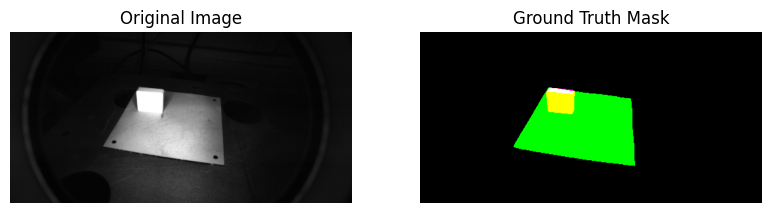

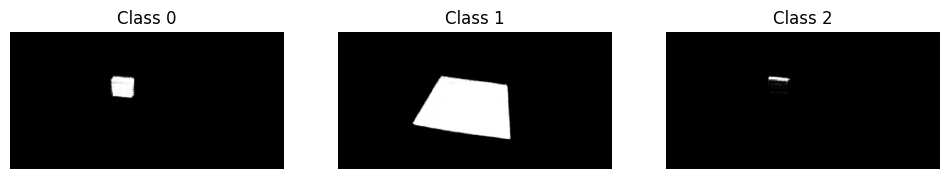

Regression: pred=[ 6.86 17.61 21.23] | true=[ 7. 18. 22.]


<Figure size 640x480 with 0 Axes>

In [74]:
import matplotlib.pyplot as plt
import torch

model.eval()

with torch.no_grad():
    it = iter(val_loader)
    imgs, masks, labels = next(it)  # Берем один батч
    imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

    seg_out, reg_out = model(imgs)

    # Выбираем один элемент из батча
    img = imgs[0].cpu()                          # [3, H, W]
    true_mask = masks[0].cpu()                   # [H, W] или [1, H, W]
    seg_logits = seg_out[0].cpu()                # [3, H, W]
    pred_mask = torch.argmax(seg_logits, dim=0)  # [H, W], значения от 0 до 2

    # Визуализация
    reg_values = reg_out[0].cpu().numpy()
    label_values = labels[0].cpu().numpy()

    plt.figure(figsize=(15, 5))

    # Оригинал
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
    plt.title("Original Image")
    plt.axis("off")

    # Истинная маска
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze().permute(1, 2, 0), cmap='gray', vmin=0, vmax=2)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # logits: [3, H, W] → бинарные маски
    pred_mask = torch.sigmoid(seg_logits).cpu().numpy()  # [3, H, W]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        axs[i].imshow(pred_mask[i], cmap='gray')
        axs[i].set_title(f"Class {i}")
        axs[i].axis("off")
    plt.show()

    print(f"Regression: pred={reg_values.round(2)} | true={label_values.round(2)}")
    plt.tight_layout()
    plt.show()

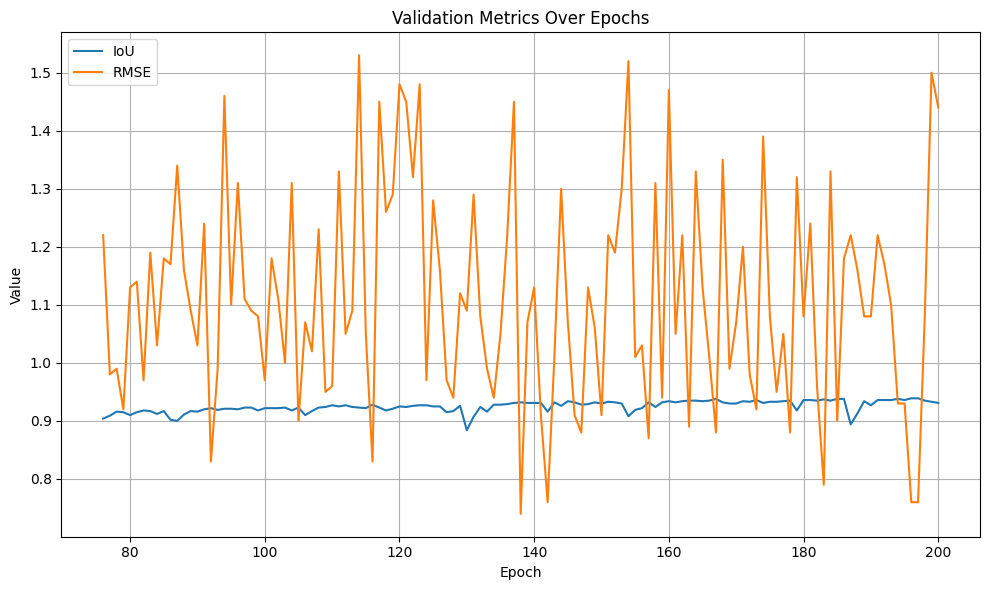

In [62]:
logs = \
'''
[Epoch 1] Training: 100%|██████████| 26/26 [00:04<00:00,  6.16it/s]
[Epoch 1] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]
[Epoch 1] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.08it/s]

Epoch 1: Train Loss = 14.1307, Val Loss = 28.2736 | IoU = 0.879, RMSE = 0.87
📌 New best model saved (val loss = 28.2736, IoU = 0.879, RMSE = 0.87) → ./drive/MyDrive/laser_model400.pth

[Epoch 2] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 2] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.91it/s]
[Epoch 2] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.90it/s]

Epoch 2: Train Loss = 5.3631, Val Loss = 33.6878 | IoU = 0.894, RMSE = 1.19

[Epoch 3] Training: 100%|██████████| 26/26 [00:03<00:00,  6.78it/s]
[Epoch 3] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.68it/s]
[Epoch 3] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.40it/s]

Epoch 3: Train Loss = 5.5126, Val Loss = 53.5221 | IoU = 0.893, RMSE = 1.74

[Epoch 4] Training: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s]
[Epoch 4] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]
[Epoch 4] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]

Epoch 4: Train Loss = 8.3764, Val Loss = 40.5833 | IoU = 0.890, RMSE = 1.35

[Epoch 5] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 5] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]
[Epoch 5] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]

Epoch 5: Train Loss = 8.7613, Val Loss = 57.2141 | IoU = 0.892, RMSE = 1.79

[Epoch 6] Training: 100%|██████████| 26/26 [00:04<00:00,  6.42it/s]
[Epoch 6] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s]
[Epoch 6] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.36it/s]

Epoch 6: Train Loss = 9.6382, Val Loss = 58.5646 | IoU = 0.892, RMSE = 1.76

[Epoch 7] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 7] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]
[Epoch 7] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.37it/s]

Epoch 7: Train Loss = 8.5193, Val Loss = 30.6779 | IoU = 0.897, RMSE = 1.06

[Epoch 8] Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s]
[Epoch 8] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s]
[Epoch 8] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]

Epoch 8: Train Loss = 6.0484, Val Loss = 30.1934 | IoU = 0.891, RMSE = 1.04

[Epoch 9] Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s]
[Epoch 9] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.20it/s]
[Epoch 9] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]

Epoch 9: Train Loss = 9.5823, Val Loss = 39.5110 | IoU = 0.873, RMSE = 1.30

[Epoch 10] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 10] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.17it/s]
[Epoch 10] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.90it/s]

Epoch 10: Train Loss = 7.2036, Val Loss = 30.5713 | IoU = 0.893, RMSE = 1.02

[Epoch 11] Training: 100%|██████████| 26/26 [00:03<00:00,  6.69it/s]
[Epoch 11] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.09it/s]
[Epoch 11] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.47it/s]

Epoch 11: Train Loss = 12.1551, Val Loss = 47.7972 | IoU = 0.885, RMSE = 1.55

[Epoch 12] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 12] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]
[Epoch 12] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]

Epoch 12: Train Loss = 23.2367, Val Loss = 58.9122 | IoU = 0.881, RMSE = 1.80

[Epoch 13] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 13] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.28it/s]
[Epoch 13] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]

Epoch 13: Train Loss = 16.7317, Val Loss = 30.4175 | IoU = 0.890, RMSE = 1.06

[Epoch 14] Training: 100%|██████████| 26/26 [00:03<00:00,  6.83it/s]
[Epoch 14] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.80it/s]
[Epoch 14] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.42it/s]

Epoch 14: Train Loss = 7.7111, Val Loss = 32.9394 | IoU = 0.891, RMSE = 1.13

[Epoch 15] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 15] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.02it/s]
[Epoch 15] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]

Epoch 15: Train Loss = 7.9558, Val Loss = 39.8371 | IoU = 0.896, RMSE = 1.40

[Epoch 16] Training: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s]
[Epoch 16] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.19it/s]
[Epoch 16] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]

Epoch 16: Train Loss = 11.3798, Val Loss = 38.8970 | IoU = 0.882, RMSE = 1.28

[Epoch 17] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 17] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]
[Epoch 17] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.69it/s]

Epoch 17: Train Loss = 7.6563, Val Loss = 44.1950 | IoU = 0.899, RMSE = 1.45

[Epoch 18] Training: 100%|██████████| 26/26 [00:03<00:00,  7.33it/s]
[Epoch 18] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]
[Epoch 18] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s]

Epoch 18: Train Loss = 4.3216, Val Loss = 32.5308 | IoU = 0.892, RMSE = 1.09

[Epoch 19] Training: 100%|██████████| 26/26 [00:03<00:00,  6.76it/s]
[Epoch 19] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.98it/s]
[Epoch 19] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.39it/s]

Epoch 19: Train Loss = 3.1471, Val Loss = 28.6822 | IoU = 0.903, RMSE = 0.94

[Epoch 20] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 20] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]
[Epoch 20] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.46it/s]

Epoch 20: Train Loss = 3.3134, Val Loss = 32.3024 | IoU = 0.905, RMSE = 1.08

[Epoch 21] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 21] Validation: 100%|██████████| 7/7 [00:00<00:00, 11.62it/s]
[Epoch 21] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]

Epoch 21: Train Loss = 3.5384, Val Loss = 41.1108 | IoU = 0.905, RMSE = 1.39

[Epoch 22] Training: 100%|██████████| 26/26 [00:03<00:00,  6.82it/s]
[Epoch 22] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.23it/s]
[Epoch 22] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]

Epoch 22: Train Loss = 2.8833, Val Loss = 35.0448 | IoU = 0.903, RMSE = 1.18

[Epoch 23] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 23] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.97it/s]
[Epoch 23] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.42it/s]

Epoch 23: Train Loss = 3.4998, Val Loss = 37.9574 | IoU = 0.904, RMSE = 1.27

[Epoch 24] Training: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s]
[Epoch 24] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]
[Epoch 24] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]

Epoch 24: Train Loss = 5.1966, Val Loss = 33.3556 | IoU = 0.902, RMSE = 1.10

[Epoch 25] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 25] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.34it/s]
[Epoch 25] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]

Epoch 25: Train Loss = 5.3755, Val Loss = 36.7510 | IoU = 0.906, RMSE = 1.25

[Epoch 26] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 26] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.54it/s]
[Epoch 26] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]

Epoch 26: Train Loss = 4.7150, Val Loss = 31.0453 | IoU = 0.906, RMSE = 0.99

[Epoch 27] Training: 100%|██████████| 26/26 [00:03<00:00,  6.70it/s]
[Epoch 27] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.02it/s]
[Epoch 27] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s]

Epoch 27: Train Loss = 2.8577, Val Loss = 40.4895 | IoU = 0.907, RMSE = 1.38

[Epoch 28] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 28] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.91it/s]
[Epoch 28] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Epoch 28: Train Loss = 4.5352, Val Loss = 35.4711 | IoU = 0.902, RMSE = 1.21

[Epoch 29] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 29] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.04it/s]
[Epoch 29] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]

Epoch 29: Train Loss = 5.0592, Val Loss = 45.5021 | IoU = 0.907, RMSE = 1.53

[Epoch 30] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 30] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.11it/s]
[Epoch 30] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]

Epoch 30: Train Loss = 8.6187, Val Loss = 39.4891 | IoU = 0.906, RMSE = 1.35

[Epoch 31] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 31] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]
[Epoch 31] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]

Epoch 31: Train Loss = 8.7876, Val Loss = 38.5341 | IoU = 0.906, RMSE = 1.32

[Epoch 32] Training: 100%|██████████| 26/26 [00:03<00:00,  6.87it/s]
[Epoch 32] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]
[Epoch 32] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]

Epoch 32: Train Loss = 5.2018, Val Loss = 33.2091 | IoU = 0.904, RMSE = 1.10

[Epoch 33] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 33] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s]
[Epoch 33] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]

Epoch 33: Train Loss = 4.5567, Val Loss = 28.8692 | IoU = 0.907, RMSE = 0.85

[Epoch 34] Training: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]
[Epoch 34] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
[Epoch 34] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]

Epoch 34: Train Loss = 2.5363, Val Loss = 28.8267 | IoU = 0.910, RMSE = 0.90

[Epoch 35] Training: 100%|██████████| 26/26 [00:03<00:00,  6.76it/s]
[Epoch 35] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]
[Epoch 35] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]

Epoch 35: Train Loss = 2.6412, Val Loss = 32.5794 | IoU = 0.911, RMSE = 1.10

[Epoch 36] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 36] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
[Epoch 36] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]

Epoch 36: Train Loss = 2.5222, Val Loss = 42.1437 | IoU = 0.907, RMSE = 1.38

[Epoch 37] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 37] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.77it/s]
[Epoch 37] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]

Epoch 37: Train Loss = 3.2284, Val Loss = 36.7211 | IoU = 0.911, RMSE = 1.24

[Epoch 38] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 38] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]
[Epoch 38] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]

Epoch 38: Train Loss = 3.1225, Val Loss = 28.6208 | IoU = 0.912, RMSE = 0.90

[Epoch 39] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 39] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]
[Epoch 39] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.36it/s]

Epoch 39: Train Loss = 2.9219, Val Loss = 51.3881 | IoU = 0.909, RMSE = 1.63

[Epoch 40] Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s]
[Epoch 40] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.99it/s]
[Epoch 40] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]

Epoch 40: Train Loss = 4.7332, Val Loss = 31.7626 | IoU = 0.910, RMSE = 1.08

[Epoch 41] Training: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]
[Epoch 41] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]
[Epoch 41] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.23it/s]

Epoch 41: Train Loss = 5.5801, Val Loss = 34.6394 | IoU = 0.911, RMSE = 1.17

[Epoch 42] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 42] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.17it/s]
[Epoch 42] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]

Epoch 42: Train Loss = 8.3875, Val Loss = 37.9834 | IoU = 0.902, RMSE = 1.35

[Epoch 43] Training: 100%|██████████| 26/26 [00:03<00:00,  6.62it/s]
[Epoch 43] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]
[Epoch 43] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]

Epoch 43: Train Loss = 10.0391, Val Loss = 39.6039 | IoU = 0.912, RMSE = 1.48

[Epoch 44] Training: 100%|██████████| 26/26 [00:03<00:00,  7.32it/s]
[Epoch 44] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.84it/s]
[Epoch 44] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]

Epoch 44: Train Loss = 12.9411, Val Loss = 49.8767 | IoU = 0.909, RMSE = 1.60

[Epoch 45] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 45] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.75it/s]
[Epoch 45] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]

Epoch 45: Train Loss = 7.8114, Val Loss = 30.5251 | IoU = 0.904, RMSE = 0.92

[Epoch 46] Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s]
[Epoch 46] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]
[Epoch 46] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]

Epoch 46: Train Loss = 16.1633, Val Loss = 32.1365 | IoU = 0.904, RMSE = 1.10

[Epoch 47] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 47] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]
[Epoch 47] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]

Epoch 47: Train Loss = 62.0068, Val Loss = 48.5045 | IoU = 0.878, RMSE = 1.57

[Epoch 48] Training: 100%|██████████| 26/26 [00:03<00:00,  6.68it/s]
[Epoch 48] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]
[Epoch 48] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]

Epoch 48: Train Loss = 129.8445, Val Loss = 62.7406 | IoU = 0.766, RMSE = 1.91

[Epoch 49] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 49] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]
[Epoch 49] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]

Epoch 49: Train Loss = 184.0499, Val Loss = 184.1013 | IoU = 0.821, RMSE = 3.55

[Epoch 50] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 50] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.34it/s]
[Epoch 50] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]

Epoch 50: Train Loss = 230.4618, Val Loss = 320.5020 | IoU = 0.617, RMSE = 4.43

[Epoch 51] Training: 100%|██████████| 26/26 [00:03<00:00,  6.66it/s]
[Epoch 51] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]
[Epoch 51] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]

Epoch 51: Train Loss = 185.0415, Val Loss = 121.6494 | IoU = 0.783, RMSE = 2.67

[Epoch 52] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 52] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]
[Epoch 52] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]

Epoch 52: Train Loss = 50.6588, Val Loss = 34.3839 | IoU = 0.829, RMSE = 1.16

[Epoch 53] Training: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s]
[Epoch 53] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]
[Epoch 53] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]

Epoch 53: Train Loss = 19.1296, Val Loss = 34.1509 | IoU = 0.874, RMSE = 1.11

[Epoch 54] Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s]
[Epoch 54] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.23it/s]
[Epoch 54] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.51it/s]

Epoch 54: Train Loss = 16.4661, Val Loss = 34.8376 | IoU = 0.865, RMSE = 1.15

[Epoch 55] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 55] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.55it/s]
[Epoch 55] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]

Epoch 55: Train Loss = 7.6497, Val Loss = 32.8153 | IoU = 0.895, RMSE = 1.14

[Epoch 56] Training: 100%|██████████| 26/26 [00:03<00:00,  6.79it/s]
[Epoch 56] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
[Epoch 56] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.75it/s]

Epoch 56: Train Loss = 7.8214, Val Loss = 33.8305 | IoU = 0.894, RMSE = 1.14

[Epoch 57] Training: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s]
[Epoch 57] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]
[Epoch 57] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]

Epoch 57: Train Loss = 6.8516, Val Loss = 30.7707 | IoU = 0.898, RMSE = 1.01

[Epoch 58] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 58] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.88it/s]
[Epoch 58] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]

Epoch 58: Train Loss = 14.7663, Val Loss = 47.9815 | IoU = 0.892, RMSE = 1.57

[Epoch 59] Training: 100%|██████████| 26/26 [00:03<00:00,  6.82it/s]
[Epoch 59] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]
[Epoch 59] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.27it/s]

Epoch 59: Train Loss = 11.1153, Val Loss = 35.3892 | IoU = 0.881, RMSE = 1.18

[Epoch 60] Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]
[Epoch 60] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]
[Epoch 60] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]

Epoch 60: Train Loss = 10.6407, Val Loss = 37.0303 | IoU = 0.875, RMSE = 1.26

[Epoch 61] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 61] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.00it/s]
[Epoch 61] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]

Epoch 61: Train Loss = 5.2410, Val Loss = 33.2262 | IoU = 0.892, RMSE = 1.11

[Epoch 62] Training: 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]
[Epoch 62] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]
[Epoch 62] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

Epoch 62: Train Loss = 14.0593, Val Loss = 47.7449 | IoU = 0.896, RMSE = 1.54

[Epoch 63] Training: 100%|██████████| 26/26 [00:03<00:00,  7.32it/s]
[Epoch 63] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s]
[Epoch 63] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Epoch 63: Train Loss = 51.1632, Val Loss = 28.5939 | IoU = 0.886, RMSE = 0.87

[Epoch 64] Training: 100%|██████████| 26/26 [00:03<00:00,  6.60it/s]
[Epoch 64] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.86it/s]
[Epoch 64] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.20it/s]

Epoch 64: Train Loss = 33.4909, Val Loss = 38.3653 | IoU = 0.816, RMSE = 1.34

[Epoch 65] Training: 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]
[Epoch 65] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]
[Epoch 65] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.85it/s]

Epoch 65: Train Loss = 16.6846, Val Loss = 52.2719 | IoU = 0.891, RMSE = 1.63

[Epoch 66] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 66] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.80it/s]
[Epoch 66] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

Epoch 66: Train Loss = 15.7244, Val Loss = 44.3261 | IoU = 0.898, RMSE = 1.51

[Epoch 67] Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s]
[Epoch 67] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]
[Epoch 67] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]

Epoch 67: Train Loss = 13.5546, Val Loss = 43.7807 | IoU = 0.907, RMSE = 1.46

[Epoch 68] Training: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]
[Epoch 68] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]
[Epoch 68] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]

Epoch 68: Train Loss = 8.4362, Val Loss = 30.1348 | IoU = 0.907, RMSE = 0.96

[Epoch 69] Training: 100%|██████████| 26/26 [00:03<00:00,  6.84it/s]
[Epoch 69] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.95it/s]
[Epoch 69] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]

Epoch 69: Train Loss = 3.0428, Val Loss = 36.1372 | IoU = 0.908, RMSE = 1.24

[Epoch 70] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 70] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.03it/s]
[Epoch 70] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.42it/s]

Epoch 70: Train Loss = 2.8937, Val Loss = 35.5721 | IoU = 0.908, RMSE = 1.23

[Epoch 71] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 71] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.16it/s]
[Epoch 71] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

Epoch 71: Train Loss = 3.3594, Val Loss = 29.4258 | IoU = 0.913, RMSE = 0.92

[Epoch 72] Training: 100%|██████████| 26/26 [00:03<00:00,  6.69it/s]
[Epoch 72] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]
[Epoch 72] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]

Epoch 72: Train Loss = 4.1834, Val Loss = 37.6280 | IoU = 0.910, RMSE = 1.30

[Epoch 73] Training: 100%|██████████| 26/26 [00:03<00:00,  7.17it/s]
[Epoch 73] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.38it/s]
[Epoch 73] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]

Epoch 73: Train Loss = 20.4545, Val Loss = 49.3220 | IoU = 0.903, RMSE = 1.60

[Epoch 74] Training: 100%|██████████| 26/26 [00:03<00:00,  7.17it/s]
[Epoch 74] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]
[Epoch 74] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]

Epoch 74: Train Loss = 6.3537, Val Loss = 27.4473 | IoU = 0.911, RMSE = 0.86
📌 New best model saved (val loss = 27.4473, IoU = 0.911, RMSE = 0.86) → ./drive/MyDrive/laser_model400.pth

[Epoch 75] Training: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s]
[Epoch 75] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.32it/s]
[Epoch 75] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

Epoch 75: Train Loss = 4.3963, Val Loss = 29.1248 | IoU = 0.907, RMSE = 0.96

[Epoch 76] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 76] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]
[Epoch 76] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.94it/s]

Epoch 76: Train Loss = 7.7511, Val Loss = 35.6686 | IoU = 0.904, RMSE = 1.22

[Epoch 77] Training: 100%|██████████| 26/26 [00:04<00:00,  6.25it/s]
[Epoch 77] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.11it/s]
[Epoch 77] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

Epoch 77: Train Loss = 4.8132, Val Loss = 30.1365 | IoU = 0.909, RMSE = 0.98

[Epoch 78] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 78] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.23it/s]
[Epoch 78] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

Epoch 78: Train Loss = 15.0869, Val Loss = 30.1847 | IoU = 0.916, RMSE = 0.99

[Epoch 79] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 79] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.79it/s]
[Epoch 79] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]

Epoch 79: Train Loss = 4.7181, Val Loss = 29.6554 | IoU = 0.915, RMSE = 0.92

[Epoch 80] Training: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s]
[Epoch 80] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
[Epoch 80] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.78it/s]

Epoch 80: Train Loss = 6.6310, Val Loss = 32.3005 | IoU = 0.910, RMSE = 1.13

[Epoch 81] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 81] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.02it/s]
[Epoch 81] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]

Epoch 81: Train Loss = 5.8766, Val Loss = 33.5184 | IoU = 0.915, RMSE = 1.14

[Epoch 82] Training: 100%|██████████| 26/26 [00:03<00:00,  6.86it/s]
[Epoch 82] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.82it/s]
[Epoch 82] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

Epoch 82: Train Loss = 4.3982, Val Loss = 29.9138 | IoU = 0.918, RMSE = 0.97

[Epoch 83] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 83] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]
[Epoch 83] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]

Epoch 83: Train Loss = 2.3748, Val Loss = 34.9103 | IoU = 0.917, RMSE = 1.19

[Epoch 84] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 84] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.76it/s]
[Epoch 84] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]

Epoch 84: Train Loss = 2.1092, Val Loss = 31.3384 | IoU = 0.912, RMSE = 1.03

[Epoch 85] Training: 100%|██████████| 26/26 [00:03<00:00,  6.51it/s]
[Epoch 85] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.84it/s]
[Epoch 85] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]

Epoch 85: Train Loss = 2.5044, Val Loss = 34.4362 | IoU = 0.917, RMSE = 1.18

[Epoch 86] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 86] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.99it/s]
[Epoch 86] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]

Epoch 86: Train Loss = 2.3662, Val Loss = 34.5153 | IoU = 0.902, RMSE = 1.17

[Epoch 87] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 87] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]
[Epoch 87] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]

Epoch 87: Train Loss = 3.9515, Val Loss = 39.4983 | IoU = 0.900, RMSE = 1.34

[Epoch 88] Training: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s]
[Epoch 88] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]
[Epoch 88] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]

Epoch 88: Train Loss = 5.2095, Val Loss = 34.3962 | IoU = 0.911, RMSE = 1.16

[Epoch 89] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 89] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]
[Epoch 89] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

Epoch 89: Train Loss = 3.6683, Val Loss = 32.6181 | IoU = 0.917, RMSE = 1.09

[Epoch 90] Training: 100%|██████████| 26/26 [00:03<00:00,  6.74it/s]
[Epoch 90] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]
[Epoch 90] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]

Epoch 90: Train Loss = 1.8842, Val Loss = 31.1215 | IoU = 0.916, RMSE = 1.03

[Epoch 91] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 91] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]
[Epoch 91] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

Epoch 91: Train Loss = 4.3076, Val Loss = 36.8274 | IoU = 0.920, RMSE = 1.24

[Epoch 92] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 92] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.19it/s]
[Epoch 92] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]

Epoch 92: Train Loss = 2.5072, Val Loss = 26.3885 | IoU = 0.922, RMSE = 0.83
📌 New best model saved (val loss = 26.3885, IoU = 0.922, RMSE = 0.83) → ./drive/MyDrive/laser_model400.pth

[Epoch 93] Training: 100%|██████████| 26/26 [00:03<00:00,  6.64it/s]
[Epoch 93] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.19it/s]
[Epoch 93] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]

Epoch 93: Train Loss = 2.3873, Val Loss = 31.1061 | IoU = 0.919, RMSE = 0.99

[Epoch 94] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 94] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]
[Epoch 94] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.19it/s]

Epoch 94: Train Loss = 2.8934, Val Loss = 44.1259 | IoU = 0.921, RMSE = 1.46

[Epoch 95] Training: 100%|██████████| 26/26 [00:04<00:00,  6.41it/s]
[Epoch 95] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]
[Epoch 95] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]

Epoch 95: Train Loss = 3.2085, Val Loss = 32.7720 | IoU = 0.921, RMSE = 1.10

[Epoch 96] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 96] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]
[Epoch 96] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]

Epoch 96: Train Loss = 2.3903, Val Loss = 38.4335 | IoU = 0.920, RMSE = 1.31

[Epoch 97] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 97] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]
[Epoch 97] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]

Epoch 97: Train Loss = 1.6923, Val Loss = 32.6972 | IoU = 0.923, RMSE = 1.11

[Epoch 98] Training: 100%|██████████| 26/26 [00:03<00:00,  6.58it/s]
[Epoch 98] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]
[Epoch 98] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

Epoch 98: Train Loss = 1.6562, Val Loss = 32.2876 | IoU = 0.923, RMSE = 1.09

[Epoch 99] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 99] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]
[Epoch 99] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.22it/s]

Epoch 99: Train Loss = 2.2127, Val Loss = 32.0930 | IoU = 0.918, RMSE = 1.08

[Epoch 100] Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]
[Epoch 100] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]
[Epoch 100] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]

Epoch 100: Train Loss = 1.9534, Val Loss = 29.9901 | IoU = 0.922, RMSE = 0.97

[Epoch 101] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 101] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]
[Epoch 101] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]

Epoch 101: Train Loss = 1.9015, Val Loss = 34.2552 | IoU = 0.922, RMSE = 1.18

[Epoch 102] Training: 100%|██████████| 26/26 [00:03<00:00,  7.33it/s]
[Epoch 102] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]
[Epoch 102] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]

Epoch 102: Train Loss = 1.9970, Val Loss = 32.9316 | IoU = 0.922, RMSE = 1.11

[Epoch 103] Training: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s]
[Epoch 103] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]
[Epoch 103] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]

Epoch 103: Train Loss = 1.8233, Val Loss = 30.2489 | IoU = 0.923, RMSE = 1.00

[Epoch 104] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 104] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]
[Epoch 104] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]

Epoch 104: Train Loss = 2.5631, Val Loss = 38.4615 | IoU = 0.918, RMSE = 1.31

[Epoch 105] Training: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]
[Epoch 105] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]
[Epoch 105] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s]

Epoch 105: Train Loss = 2.8013, Val Loss = 28.7559 | IoU = 0.923, RMSE = 0.90

[Epoch 106] Training: 100%|██████████| 26/26 [00:03<00:00,  6.83it/s]
[Epoch 106] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.49it/s]
[Epoch 106] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.89it/s]

Epoch 106: Train Loss = 2.7581, Val Loss = 32.2397 | IoU = 0.910, RMSE = 1.07

[Epoch 107] Training: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]
[Epoch 107] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]
[Epoch 107] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.81it/s]

Epoch 107: Train Loss = 1.3878, Val Loss = 30.9660 | IoU = 0.917, RMSE = 1.02

[Epoch 108] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 108] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s]
[Epoch 108] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]

Epoch 108: Train Loss = 1.2257, Val Loss = 36.3015 | IoU = 0.923, RMSE = 1.23

[Epoch 109] Training: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s]
[Epoch 109] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]
[Epoch 109] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]

Epoch 109: Train Loss = 2.8192, Val Loss = 29.8400 | IoU = 0.924, RMSE = 0.95

[Epoch 110] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 110] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.32it/s]
[Epoch 110] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]

Epoch 110: Train Loss = 1.7482, Val Loss = 29.5286 | IoU = 0.927, RMSE = 0.96

[Epoch 111] Training: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s]
[Epoch 111] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s]
[Epoch 111] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]

Epoch 111: Train Loss = 1.8219, Val Loss = 39.0562 | IoU = 0.925, RMSE = 1.33

[Epoch 112] Training: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]
[Epoch 112] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]
[Epoch 112] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]

Epoch 112: Train Loss = 3.8903, Val Loss = 31.8618 | IoU = 0.927, RMSE = 1.05

[Epoch 113] Training: 100%|██████████| 26/26 [00:03<00:00,  7.32it/s]
[Epoch 113] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.33it/s]
[Epoch 113] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

Epoch 113: Train Loss = 5.3449, Val Loss = 32.6733 | IoU = 0.924, RMSE = 1.09

[Epoch 114] Training: 100%|██████████| 26/26 [00:03<00:00,  6.64it/s]
[Epoch 114] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.23it/s]
[Epoch 114] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.80it/s]

Epoch 114: Train Loss = 7.1252, Val Loss = 46.5752 | IoU = 0.923, RMSE = 1.53

[Epoch 115] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 115] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]
[Epoch 115] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.22it/s]

Epoch 115: Train Loss = 3.8188, Val Loss = 29.6152 | IoU = 0.922, RMSE = 1.05

[Epoch 116] Training: 100%|██████████| 26/26 [00:03<00:00,  7.16it/s]
[Epoch 116] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.09it/s]
[Epoch 116] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

Epoch 116: Train Loss = 2.4960, Val Loss = 26.6503 | IoU = 0.928, RMSE = 0.83

[Epoch 117] Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s]
[Epoch 117] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]
[Epoch 117] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]

Epoch 117: Train Loss = 13.5955, Val Loss = 42.2716 | IoU = 0.923, RMSE = 1.45

[Epoch 118] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 118] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]
[Epoch 118] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Epoch 118: Train Loss = 6.1222, Val Loss = 35.7104 | IoU = 0.918, RMSE = 1.26

[Epoch 119] Training: 100%|██████████| 26/26 [00:03<00:00,  6.91it/s]
[Epoch 119] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]
[Epoch 119] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]

Epoch 119: Train Loss = 4.4750, Val Loss = 36.4712 | IoU = 0.921, RMSE = 1.29

[Epoch 120] Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]
[Epoch 120] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.83it/s]
[Epoch 120] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.14it/s]

Epoch 120: Train Loss = 6.5927, Val Loss = 44.9006 | IoU = 0.925, RMSE = 1.48

[Epoch 121] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 121] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]
[Epoch 121] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

Epoch 121: Train Loss = 4.9693, Val Loss = 43.0525 | IoU = 0.924, RMSE = 1.45

[Epoch 122] Training: 100%|██████████| 26/26 [00:03<00:00,  6.54it/s]
[Epoch 122] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s]
[Epoch 122] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]

Epoch 122: Train Loss = 7.1218, Val Loss = 36.5973 | IoU = 0.926, RMSE = 1.32

[Epoch 123] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 123] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.98it/s]
[Epoch 123] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]

Epoch 123: Train Loss = 4.7826, Val Loss = 44.4809 | IoU = 0.927, RMSE = 1.48

[Epoch 124] Training: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s]
[Epoch 124] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.56it/s]
[Epoch 124] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]

Epoch 124: Train Loss = 3.1046, Val Loss = 30.2382 | IoU = 0.927, RMSE = 0.97

[Epoch 125] Training: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s]
[Epoch 125] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.38it/s]
[Epoch 125] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]

Epoch 125: Train Loss = 3.9724, Val Loss = 37.6917 | IoU = 0.925, RMSE = 1.28

[Epoch 126] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 126] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]
[Epoch 126] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]

Epoch 126: Train Loss = 2.8406, Val Loss = 33.5795 | IoU = 0.925, RMSE = 1.16

[Epoch 127] Training: 100%|██████████| 26/26 [00:03<00:00,  6.87it/s]
[Epoch 127] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.07it/s]
[Epoch 127] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]

Epoch 127: Train Loss = 16.5590, Val Loss = 30.5830 | IoU = 0.915, RMSE = 0.97

[Epoch 128] Training: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]
[Epoch 128] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.75it/s]
[Epoch 128] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

Epoch 128: Train Loss = 7.2051, Val Loss = 28.5698 | IoU = 0.917, RMSE = 0.94

[Epoch 129] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 129] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.16it/s]
[Epoch 129] Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]

Epoch 129: Train Loss = 9.9664, Val Loss = 33.4619 | IoU = 0.926, RMSE = 1.12

[Epoch 130] Training: 100%|██████████| 26/26 [00:03<00:00,  6.75it/s]
[Epoch 130] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.96it/s]
[Epoch 130] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]

Epoch 130: Train Loss = 8.3631, Val Loss = 30.4240 | IoU = 0.884, RMSE = 1.09

[Epoch 131] Training: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]
[Epoch 131] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.84it/s]
[Epoch 131] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]

Epoch 131: Train Loss = 6.5017, Val Loss = 36.3904 | IoU = 0.907, RMSE = 1.29

[Epoch 132] Training: 100%|██████████| 26/26 [00:03<00:00,  7.08it/s]
[Epoch 132] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]
[Epoch 132] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

Epoch 132: Train Loss = 4.8455, Val Loss = 31.5526 | IoU = 0.924, RMSE = 1.08

[Epoch 133] Training: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s]
[Epoch 133] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s]
[Epoch 133] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]

Epoch 133: Train Loss = 2.8376, Val Loss = 28.7025 | IoU = 0.916, RMSE = 0.99

[Epoch 134] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 134] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]
[Epoch 134] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]

Epoch 134: Train Loss = 1.5600, Val Loss = 28.1779 | IoU = 0.928, RMSE = 0.94

[Epoch 135] Training: 100%|██████████| 26/26 [00:03<00:00,  6.63it/s]
[Epoch 135] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]
[Epoch 135] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.04it/s]

Epoch 135: Train Loss = 1.6809, Val Loss = 30.1589 | IoU = 0.928, RMSE = 1.05

[Epoch 136] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 136] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.17it/s]
[Epoch 136] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.00it/s]

Epoch 136: Train Loss = 2.5366, Val Loss = 35.0220 | IoU = 0.929, RMSE = 1.22

[Epoch 137] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 137] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s]
[Epoch 137] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

Epoch 137: Train Loss = 5.8249, Val Loss = 43.6850 | IoU = 0.931, RMSE = 1.45

[Epoch 138] Training: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s]
[Epoch 138] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]
[Epoch 138] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

Epoch 138: Train Loss = 4.5851, Val Loss = 24.6761 | IoU = 0.932, RMSE = 0.74
📌 New best model saved (val loss = 24.6761, IoU = 0.932, RMSE = 0.74) → ./drive/MyDrive/laser_model400.pth

[Epoch 139] Training: 100%|██████████| 26/26 [00:03<00:00,  7.14it/s]
[Epoch 139] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]
[Epoch 139] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

Epoch 139: Train Loss = 4.4296, Val Loss = 32.8346 | IoU = 0.931, RMSE = 1.07

[Epoch 140] Training: 100%|██████████| 26/26 [00:03<00:00,  6.80it/s]
[Epoch 140] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]
[Epoch 140] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]

Epoch 140: Train Loss = 3.0206, Val Loss = 33.9230 | IoU = 0.931, RMSE = 1.13

[Epoch 141] Training: 100%|██████████| 26/26 [00:03<00:00,  6.65it/s]
[Epoch 141] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.00it/s]
[Epoch 141] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

Epoch 141: Train Loss = 4.3155, Val Loss = 28.8870 | IoU = 0.931, RMSE = 0.91

[Epoch 142] Training: 100%|██████████| 26/26 [00:03<00:00,  7.10it/s]
[Epoch 142] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]
[Epoch 142] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]

Epoch 142: Train Loss = 3.0110, Val Loss = 26.1420 | IoU = 0.916, RMSE = 0.76

[Epoch 143] Training: 100%|██████████| 26/26 [00:03<00:00,  6.70it/s]
[Epoch 143] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.87it/s]
[Epoch 143] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]

Epoch 143: Train Loss = 1.9681, Val Loss = 31.1491 | IoU = 0.932, RMSE = 1.01

[Epoch 144] Training: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]
[Epoch 144] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.11it/s]
[Epoch 144] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]

Epoch 144: Train Loss = 2.1961, Val Loss = 39.0225 | IoU = 0.926, RMSE = 1.30

[Epoch 145] Training: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s]
[Epoch 145] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s]
[Epoch 145] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]

Epoch 145: Train Loss = 1.8791, Val Loss = 31.7929 | IoU = 0.934, RMSE = 1.07

[Epoch 146] Training: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s]
[Epoch 146] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]
[Epoch 146] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]

Epoch 146: Train Loss = 2.1280, Val Loss = 28.4822 | IoU = 0.932, RMSE = 0.91

[Epoch 147] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 147] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]
[Epoch 147] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]

Epoch 147: Train Loss = 1.5941, Val Loss = 28.4509 | IoU = 0.928, RMSE = 0.88

[Epoch 148] Training: 100%|██████████| 26/26 [00:03<00:00,  6.73it/s]
[Epoch 148] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]
[Epoch 148] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.27it/s]

Epoch 148: Train Loss = 2.1916, Val Loss = 33.7232 | IoU = 0.929, RMSE = 1.13

[Epoch 149] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 149] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.85it/s]
[Epoch 149] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.75it/s]

Epoch 149: Train Loss = 1.9728, Val Loss = 31.1838 | IoU = 0.932, RMSE = 1.06

[Epoch 150] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 150] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.15it/s]
[Epoch 150] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]

Epoch 150: Train Loss = 3.0169, Val Loss = 28.3244 | IoU = 0.930, RMSE = 0.91

[Epoch 151] Training: 100%|██████████| 26/26 [00:03<00:00,  6.79it/s]
[Epoch 151] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.75it/s]
[Epoch 151] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.69it/s]

Epoch 151: Train Loss = 5.7178, Val Loss = 35.4085 | IoU = 0.933, RMSE = 1.22

[Epoch 152] Training: 100%|██████████| 26/26 [00:03<00:00,  7.08it/s]
[Epoch 152] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.16it/s]
[Epoch 152] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]

Epoch 152: Train Loss = 5.7740, Val Loss = 34.9992 | IoU = 0.932, RMSE = 1.19

[Epoch 153] Training: 100%|██████████| 26/26 [00:03<00:00,  6.79it/s]
[Epoch 153] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.03it/s]
[Epoch 153] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

Epoch 153: Train Loss = 6.4952, Val Loss = 37.8967 | IoU = 0.930, RMSE = 1.30

[Epoch 154] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 154] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]
[Epoch 154] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Epoch 154: Train Loss = 5.2502, Val Loss = 46.6360 | IoU = 0.908, RMSE = 1.52

[Epoch 155] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 155] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]
[Epoch 155] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]

Epoch 155: Train Loss = 4.1029, Val Loss = 30.5191 | IoU = 0.919, RMSE = 1.01

[Epoch 156] Training: 100%|██████████| 26/26 [00:03<00:00,  6.56it/s]
[Epoch 156] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]
[Epoch 156] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]

Epoch 156: Train Loss = 2.2285, Val Loss = 32.1400 | IoU = 0.922, RMSE = 1.03

[Epoch 157] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 157] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]
[Epoch 157] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]

Epoch 157: Train Loss = 2.0598, Val Loss = 28.0121 | IoU = 0.932, RMSE = 0.87

[Epoch 158] Training: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s]
[Epoch 158] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s]
[Epoch 158] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]

Epoch 158: Train Loss = 2.0844, Val Loss = 38.4679 | IoU = 0.924, RMSE = 1.31

[Epoch 159] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 159] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]
[Epoch 159] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]

Epoch 159: Train Loss = 2.0320, Val Loss = 28.9656 | IoU = 0.932, RMSE = 0.94

[Epoch 160] Training: 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]
[Epoch 160] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]
[Epoch 160] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

Epoch 160: Train Loss = 1.9857, Val Loss = 43.8366 | IoU = 0.934, RMSE = 1.47

[Epoch 161] Training: 100%|██████████| 26/26 [00:03<00:00,  6.83it/s]
[Epoch 161] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.36it/s]
[Epoch 161] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]

Epoch 161: Train Loss = 2.7025, Val Loss = 31.3142 | IoU = 0.932, RMSE = 1.05

[Epoch 162] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 162] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.50it/s]
[Epoch 162] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]

Epoch 162: Train Loss = 5.9469, Val Loss = 36.0643 | IoU = 0.934, RMSE = 1.22

[Epoch 163] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 163] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s]
[Epoch 163] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]

Epoch 163: Train Loss = 3.9874, Val Loss = 28.4958 | IoU = 0.935, RMSE = 0.89

[Epoch 164] Training: 100%|██████████| 26/26 [00:03<00:00,  6.76it/s]
[Epoch 164] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.53it/s]
[Epoch 164] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]

Epoch 164: Train Loss = 4.2949, Val Loss = 38.5987 | IoU = 0.935, RMSE = 1.33

[Epoch 165] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 165] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]
[Epoch 165] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]

Epoch 165: Train Loss = 2.9574, Val Loss = 33.2493 | IoU = 0.934, RMSE = 1.13

[Epoch 166] Training: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s]
[Epoch 166] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]
[Epoch 166] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

Epoch 166: Train Loss = 5.0588, Val Loss = 31.3765 | IoU = 0.935, RMSE = 1.01

[Epoch 167] Training: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s]
[Epoch 167] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]
[Epoch 167] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]

Epoch 167: Train Loss = 4.1456, Val Loss = 28.0475 | IoU = 0.938, RMSE = 0.88

[Epoch 168] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 168] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.50it/s]
[Epoch 168] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

Epoch 168: Train Loss = 2.2374, Val Loss = 39.9765 | IoU = 0.932, RMSE = 1.35

[Epoch 169] Training: 100%|██████████| 26/26 [00:03<00:00,  6.76it/s]
[Epoch 169] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]
[Epoch 169] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]

Epoch 169: Train Loss = 3.6051, Val Loss = 29.7008 | IoU = 0.930, RMSE = 0.99

[Epoch 170] Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]
[Epoch 170] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.26it/s]
[Epoch 170] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]

Epoch 170: Train Loss = 4.5173, Val Loss = 33.0272 | IoU = 0.930, RMSE = 1.07

[Epoch 171] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 171] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s]
[Epoch 171] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]

Epoch 171: Train Loss = 4.0057, Val Loss = 34.0963 | IoU = 0.934, RMSE = 1.20

[Epoch 172] Training: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s]
[Epoch 172] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]
[Epoch 172] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]

Epoch 172: Train Loss = 3.2259, Val Loss = 30.3405 | IoU = 0.933, RMSE = 0.98

[Epoch 173] Training: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]
[Epoch 173] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]
[Epoch 173] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]

Epoch 173: Train Loss = 2.7806, Val Loss = 29.4878 | IoU = 0.936, RMSE = 0.92

[Epoch 174] Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]
[Epoch 174] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]
[Epoch 174] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

Epoch 174: Train Loss = 3.9243, Val Loss = 41.0530 | IoU = 0.931, RMSE = 1.39

[Epoch 175] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 175] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s]
[Epoch 175] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.64it/s]

Epoch 175: Train Loss = 6.3768, Val Loss = 32.8469 | IoU = 0.933, RMSE = 1.08

[Epoch 176] Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]
[Epoch 176] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]
[Epoch 176] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]

Epoch 176: Train Loss = 4.1338, Val Loss = 29.0118 | IoU = 0.933, RMSE = 0.95

[Epoch 177] Training: 100%|██████████| 26/26 [00:03<00:00,  6.58it/s]
[Epoch 177] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]
[Epoch 177] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]

Epoch 177: Train Loss = 4.6725, Val Loss = 30.4662 | IoU = 0.934, RMSE = 1.05

[Epoch 178] Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]
[Epoch 178] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]
[Epoch 178] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]

Epoch 178: Train Loss = 3.3146, Val Loss = 28.3176 | IoU = 0.935, RMSE = 0.88

[Epoch 179] Training: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s]
[Epoch 179] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]
[Epoch 179] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]

Epoch 179: Train Loss = 2.5353, Val Loss = 38.6587 | IoU = 0.918, RMSE = 1.32

[Epoch 180] Training: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s]
[Epoch 180] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.91it/s]
[Epoch 180] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.82it/s]

Epoch 180: Train Loss = 2.6071, Val Loss = 32.3515 | IoU = 0.936, RMSE = 1.08

[Epoch 181] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 181] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s]
[Epoch 181] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]

Epoch 181: Train Loss = 2.5653, Val Loss = 36.0849 | IoU = 0.936, RMSE = 1.24

[Epoch 182] Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s]
[Epoch 182] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.01it/s]
[Epoch 182] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]

Epoch 182: Train Loss = 3.1039, Val Loss = 29.7561 | IoU = 0.935, RMSE = 0.96

[Epoch 183] Training: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]
[Epoch 183] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s]
[Epoch 183] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]

Epoch 183: Train Loss = 3.0506, Val Loss = 26.5279 | IoU = 0.937, RMSE = 0.79

[Epoch 184] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 184] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.38it/s]
[Epoch 184] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]

Epoch 184: Train Loss = 3.4231, Val Loss = 39.0929 | IoU = 0.935, RMSE = 1.33

[Epoch 185] Training: 100%|██████████| 26/26 [00:03<00:00,  6.75it/s]
[Epoch 185] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]
[Epoch 185] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]

Epoch 185: Train Loss = 2.4341, Val Loss = 28.8853 | IoU = 0.938, RMSE = 0.90

[Epoch 186] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 186] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]
[Epoch 186] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]

Epoch 186: Train Loss = 1.9329, Val Loss = 35.3956 | IoU = 0.938, RMSE = 1.18

[Epoch 187] Training: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s]
[Epoch 187] Validation: 100%|██████████| 7/7 [00:00<00:00, 10.15it/s]
[Epoch 187] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

Epoch 187: Train Loss = 3.7753, Val Loss = 36.5803 | IoU = 0.894, RMSE = 1.22

[Epoch 188] Training: 100%|██████████| 26/26 [00:03<00:00,  6.89it/s]
[Epoch 188] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]
[Epoch 188] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]

Epoch 188: Train Loss = 6.3547, Val Loss = 33.0289 | IoU = 0.913, RMSE = 1.16

[Epoch 189] Training: 100%|██████████| 26/26 [00:03<00:00,  7.16it/s]
[Epoch 189] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.93it/s]
[Epoch 189] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]

Epoch 189: Train Loss = 4.7457, Val Loss = 32.8755 | IoU = 0.934, RMSE = 1.08

[Epoch 190] Training: 100%|██████████| 26/26 [00:03<00:00,  6.64it/s]
[Epoch 190] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.19it/s]
[Epoch 190] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]

Epoch 190: Train Loss = 6.0900, Val Loss = 32.4301 | IoU = 0.927, RMSE = 1.08

[Epoch 191] Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s]
[Epoch 191] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.46it/s]
[Epoch 191] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

Epoch 191: Train Loss = 8.2883, Val Loss = 36.7744 | IoU = 0.936, RMSE = 1.22

[Epoch 192] Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]
[Epoch 192] Validation: 100%|██████████| 7/7 [00:00<00:00, 11.09it/s]
[Epoch 192] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]

Epoch 192: Train Loss = 8.0932, Val Loss = 34.0587 | IoU = 0.936, RMSE = 1.17

[Epoch 193] Training: 100%|██████████| 26/26 [00:03<00:00,  6.61it/s]
[Epoch 193] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]
[Epoch 193] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.11it/s]

Epoch 193: Train Loss = 7.0476, Val Loss = 33.1622 | IoU = 0.936, RMSE = 1.10

[Epoch 194] Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]
[Epoch 194] Validation: 100%|██████████| 7/7 [00:00<00:00, 12.76it/s]
[Epoch 194] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Epoch 194: Train Loss = 3.5232, Val Loss = 29.3237 | IoU = 0.938, RMSE = 0.93

[Epoch 195] Training: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s]
[Epoch 195] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.72it/s]
[Epoch 195] Validation: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

Epoch 195: Train Loss = 2.0865, Val Loss = 28.8168 | IoU = 0.936, RMSE = 0.93

[Epoch 196] Training: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]
[Epoch 196] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]
[Epoch 196] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

Epoch 196: Train Loss = 2.0087, Val Loss = 27.0597 | IoU = 0.939, RMSE = 0.76

[Epoch 197] Training: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s]
[Epoch 197] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.33it/s]
[Epoch 197] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]

Epoch 197: Train Loss = 3.9373, Val Loss = 27.6470 | IoU = 0.939, RMSE = 0.76

[Epoch 198] Training: 100%|██████████| 26/26 [00:03<00:00,  6.71it/s]
[Epoch 198] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]
[Epoch 198] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.90it/s]

Epoch 198: Train Loss = 8.4120, Val Loss = 32.2011 | IoU = 0.935, RMSE = 1.08

[Epoch 199] Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]
[Epoch 199] Validation: 100%|██████████| 7/7 [00:00<00:00, 13.32it/s]
[Epoch 199] Validation: 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

Epoch 199: Train Loss = 7.7226, Val Loss = 46.1928 | IoU = 0.933, RMSE = 1.50

[Epoch 200] Training: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]
[Epoch 200] Validation: 100%|██████████| 7/7 [00:00<00:00,  9.82it/s]
[Epoch 200] Validation: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

Epoch 200: Train Loss = 8.6542, Val Loss = 43.3939 | IoU = 0.931, RMSE = 1.44
✅ Обучение завершено. Лучшая вал. потеря: 24.6761

'''

logs = logs.split('\n')
IoUs = []
val_losses = []
rmses = []
for row in logs:
  if 'Val Loss = ' in row:
    row_ = row.split()
    val_losses.append(float(row_[9]))
    IoUs.append(float(row_[13].replace(',', '')))
    rmses.append(float(row_[16]))

epochs = list(range(1, len(val_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs[75:], val_losses[75:], label='Val Loss')
plt.plot(epochs[75:], IoUs[75:], label='IoU')
plt.plot(epochs[75:], rmses[75:], label='RMSE')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()